In [5]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [6]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
        
    # read all text
    text = file.read()
    file.close()
    return text

In [7]:
#split the sentences in the .txt file with '\t'
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [8]:
data = read_text("spa-eng\spa.txt")

In [10]:
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [11]:
#print the seperated words from the .txt file
print(spa_eng)

[['Go.' 'Ve.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)']
 ['Go.' 'Vete.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)']
 ['Go.' 'Vaya.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)']
 ...
 ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.'
  'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #953962 (CK) & #1218695 (marcelostockle)']
 ['It may be impossible to get a completely error-free corpus due to the nature 

In [12]:
print(len(spa_eng))

134736


In [15]:
#we will use only first 50,000 sentences among the total ones & consider only first 2 columns with spanish & english words
spa_eng = spa_eng[:50000,:2]

In [17]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Work never ends, does it?',
        'El trabajo nunca se acaba, ¿verdad?'],
       ['Would you go out with me?', '¿Saldrías conmigo?'],
       ['Would you let me through?', '¿Me dejarías pasar?']],
      dtype='<U332')

In [18]:
# Remove punctuation (data cleaning)
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [19]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['Work never ends does it', 'El trabajo nunca se acaba ¿verdad'],
       ['Would you go out with me', '¿Saldrías conmigo'],
       ['Would you let me through', '¿Me dejarías pasar']], dtype='<U332')

In [20]:
# convert text to lowercase(data cleaning)
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()

In [21]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['work never ends does it', 'el trabajo nunca se acaba ¿verdad'],
       ['would you go out with me', '¿saldrías conmigo'],
       ['would you let me through', '¿me dejarías pasar']], dtype='<U332')

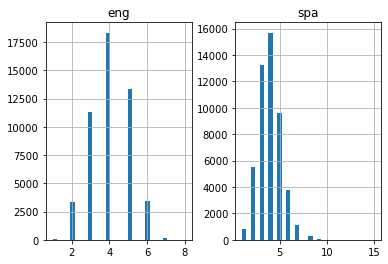

In [22]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
      eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
      spa_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})

length_df.hist(bins = 30)
plt.show()

In [23]:
#print the max english sentence length
print(max(eng_l))
#print the max spanish sentence length
print(max(spa_l))

8
15


In [24]:
# function to build a tokenizer (tokenization)
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [25]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6883


In [26]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14061


In [27]:
# encode and pad sequences (padding)
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [28]:
#Model Building
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

In [29]:
# prepare training data by encoding spanish sentences as input sequences and english as output sequences
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data by encoding spanish sentences as input sequences and english as output sequences
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [30]:
# build NMT model


#-----------Model Architecture-----------------

#INPUT-->EMBEDDING-->ENCODER-->DECODER-->DENSE-->OUTPUT

#----------------------------------------------

#For the encoder, we will use an embedding layer and an LSTM layer
#For the decoder, we will use another LSTM layer followed by a dense layer

def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    #encoder
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    #decoder
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [31]:
# model compilation
model = define_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)

In [32]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [33]:
filename = 'model.h1.26_jul_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [34]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 106s 2s/step - loss: 4.7383 - val_loss: 3.2027

Epoch 00001: val_loss improved from inf to 3.20273, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 2/30
63/63 [==============================] - 100s 2s/step - loss: 3.1365 - val_loss: 3.1020

Epoch 00002: val_loss improved from 3.20273 to 3.10199, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 3/30
63/63 [==============================] - 98s 2s/step - loss: 2.9808 - val_loss: 2.9272

Epoch 00003: val_loss improved from 3.10199 to 2.92720, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 4/30
63/63 [==============================] - 103s 2s/step - loss: 2.8513 - val_loss: 2.8584

Epoch 00004: val_loss improved from 2.92720 to 2.85837, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 5/30
63/63 [==============================] - 105s 2s/step - loss: 2.7202 - val_loss: 2.7402

Epoch 00005: val_loss improved from 2.85837 to 2.74021, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 6/30
63/63 [==============================] - 109s 2s/step - loss: 2.5755 - val_loss: 2.6054

Epoch 00006: val_loss improved from 2.74021 to 2.60541, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 7/30
63/63 [==============================] - 107s 2s/step - loss: 2.4156 - val_loss: 2.5174

Epoch 00007: val_loss improved from 2.60541 to 2.51739, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 8/30
63/63 [==============================] - 123s 2s/step - loss: 2.2694 - val_loss: 2.4114

Epoch 00008: val_loss improved from 2.51739 to 2.41136, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 9/30
63/63 [==============================] - 147s 2s/step - loss: 2.1292 - val_loss: 2.3024

Epoch 00009: val_loss improved from 2.41136 to 2.30238, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 10/30
63/63 [==============================] - 141s 2s/step - loss: 2.0000 - val_loss: 2.2621

Epoch 00010: val_loss improved from 2.30238 to 2.26212, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 11/30
63/63 [==============================] - 149s 2s/step - loss: 1.8933 - val_loss: 2.1695

Epoch 00011: val_loss improved from 2.26212 to 2.16949, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 12/30
63/63 [==============================] - 150s 2s/step - loss: 1.7813 - val_loss: 2.1032

Epoch 00012: val_loss improved from 2.16949 to 2.10320, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 13/30
63/63 [==============================] - 146s 2s/step - loss: 1.6809 - val_loss: 2.0801

Epoch 00013: val_loss improved from 2.10320 to 2.08014, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 14/30
63/63 [==============================] - 140s 2s/step - loss: 1.5864 - val_loss: 2.0256

Epoch 00014: val_loss improved from 2.08014 to 2.02562, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 15/30
63/63 [==============================] - 122s 2s/step - loss: 1.5046 - val_loss: 1.9645

Epoch 00015: val_loss improved from 2.02562 to 1.96451, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 16/30
63/63 [==============================] - 122s 2s/step - loss: 1.4122 - val_loss: 1.9288

Epoch 00016: val_loss improved from 1.96451 to 1.92884, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 17/30
63/63 [==============================] - 130s 2s/step - loss: 1.3279 - val_loss: 1.9224

Epoch 00017: val_loss improved from 1.92884 to 1.92241, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 18/30
63/63 [==============================] - 149s 2s/step - loss: 1.2500 - val_loss: 1.8798

Epoch 00018: val_loss improved from 1.92241 to 1.87980, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 19/30
63/63 [==============================] - 151s 2s/step - loss: 1.1654 - val_loss: 1.8411

Epoch 00019: val_loss improved from 1.87980 to 1.84106, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 20/30
63/63 [==============================] - 152s 2s/step - loss: 1.0974 - val_loss: 1.8509

Epoch 00020: val_loss did not improve from 1.84106
Epoch 21/30
63/63 [==============================] - 152s 2s/step - loss: 1.0353 - val_loss: 1.7957

Epoch 00021: val_loss improved from 1.84106 to 1.79570, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 22/30
63/63 [==============================] - 130s 2s/step - loss: 0.9555 - val_loss: 1.7788

Epoch 00022: val_loss improved from 1.79570 to 1.77875, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 23/30
63/63 [==============================] - 105s 2s/step - loss: 0.8943 - val_loss: 1.7668

Epoch 00023: val_loss improved from 1.77875 to 1.76684, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 24/30
63/63 [==============================] - 110s 2s/step - loss: 0.8398 - val_loss: 1.7332

Epoch 00024: val_loss improved from 1.76684 to 1.73315, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 25/30
63/63 [==============================] - 113s 2s/step - loss: 0.7747 - val_loss: 1.7337

Epoch 00025: val_loss did not improve from 1.73315
Epoch 26/30
63/63 [==============================] - 122s 2s/step - loss: 0.7183 - val_loss: 1.7210

Epoch 00026: val_loss improved from 1.73315 to 1.72102, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 27/30
63/63 [==============================] - 112s 2s/step - loss: 0.6647 - val_loss: 1.7083

Epoch 00027: val_loss improved from 1.72102 to 1.70831, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 28/30
63/63 [==============================] - 114s 2s/step - loss: 0.6117 - val_loss: 1.7106

Epoch 00028: val_loss did not improve from 1.70831
Epoch 29/30
63/63 [==============================] - 121s 2s/step - loss: 0.5669 - val_loss: 1.6988

Epoch 00029: val_loss improved from 1.70831 to 1.69882, saving model to model.h1.26_jul_21


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


INFO:tensorflow:Assets written to: model.h1.26_jul_21\assets


Epoch 30/30
63/63 [==============================] - 114s 2s/step - loss: 0.5236 - val_loss: 1.7020

Epoch 00030: val_loss did not improve from 1.69882


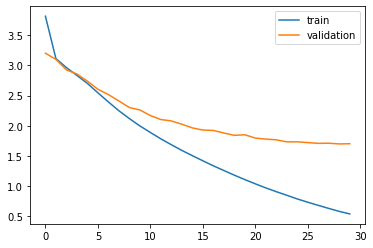

In [35]:
#compare the training loss and the validation loss.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [43]:
#we can load the saved model and make predictions on the unseen data – testX.
model = load_model('model.h1.26_jul_21')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\sphaniraj\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [44]:
#These predictions are in integers ,need to convert to their corresponding words.
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [45]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                    temp.append('')
            else:
                    temp.append(t)
        else:
                if(t == None):
                        temp.append('')
                else:
                        temp.append(t) 

    preds_text.append(' '.join(temp))

In [46]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [47]:
pred_df.head(15)

,actual,predicted
0,tom has a big problem,tom has a real
1,dont yell,dont yell
2,leave tomorrow,go yourself
3,i hate karaoke,i hate tomatoes
4,they didnt do anything,they didnt nothing anything
5,could you stay a minute,can you have a minute
6,do you know how to dance,can you dance
7,i loosened my shoelaces,my of my shoes
8,tom seldom laughs,tom rarely laughs
9,im simply doing my job,im am my job


In [50]:
pred_df.tail(15)

,actual,predicted
9985,i know who got hurt,i know who they is
9986,he can be trusted,he can be on
9987,i dont wear a watch,i dont have my tie
9988,he is wearing glasses,he is wearing glasses
9989,which dog is yours,which your is yours
9990,no one will survive,no one will
9991,please be patient,please be patient
9992,finish this,this
9993,i asked a favor of him,i asked him a favor
9994,im from the fbi,im on the


In [51]:
pred_df.sample(15)

,actual,predicted
5219,i need a crew,i need a paper days
2150,tom didnt want anything,tom didnt want anything
6347,they enjoyed themselves,they were getting
8579,youll have to trust me,you have to me
1416,youre not a doctor,youre not a doctor
1466,you should stop that,you should see that
7613,tom couldve been killed,tom never been
3060,i met your friend,i met my friend
895,bring a bucket of apples,get your umbrella
7318,tom and mary are tired,tom and mary crazy


In [288]:
sentence = 'él es tu padre'
len1=max(sentence.split(), key=len)
b1=len(len1)
sentence = [spa_tokenizer.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=b1, padding='post')
predictions = model.predict_classes(sentence)

In [289]:
predictions

array([[ 85,  21, 222,   0,   0,   0,   0,   0]], dtype=int64)

In [290]:
b1

5

In [291]:
preds_text = []
for i in predictions:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                    temp.append('')
            else:
                    temp.append(t)
        else:
                if(t == None):
                        temp.append('')
                else:
                        temp.append(t) 

    preds_text.append(' '.join(temp))

In [292]:
preds_text

['hes your father     ']